<h3>Imports and setup</h3>

In [18]:
from pathlib import Path
import os
import tifffile
import czifile
from tqdm import tqdm
import napari
from napari.utils import nbscreenshot
import pandas as pd
import numpy as np
from skimage import measure
import shutil
from sklearn.model_selection import train_test_split


<h3>Image data scraping</h3>

In [19]:
# Define the directory containing the raw .czi files and annotations
directory_path = Path("./apeer_annotations/")

# Initialize an empty list to store the .czi and ome.tiff annotation filepaths
czi_images = []
annotations = []

# Iterate through the files in the directory
for file_path in directory_path.glob('*.czi'):
    # Append the file to the corresponding group
    czi_images.append(str(file_path))

# Iterate through the files in the directory
for file_path in directory_path.glob('*.tiff'):
    # Append the file to the corresponding group
    annotations.append(str(file_path))


<h3>Transforming .czi files into .tiff</h3>

In [20]:
# Define output directory for .tiff converted .czi files  
processed_czi_dir = "./processed_bf_organoids/images"

# Check if the output folder exists, create it if not
try:
    os.makedirs(processed_czi_dir)
    print(f"Output folder created: {processed_czi_dir}")
except FileExistsError:
    print(f"Output folder already exists: {processed_czi_dir}")
    
for filepath in tqdm(czi_images):
    # Get the filename without the extension
    filename = Path(filepath).stem

    # Read the .czi file and remove singleton dimensions
    img = czifile.imread(filepath)
    img = img.squeeze()

    # Save the image as a regular .tiff file under processed_bf_organoids/images
    tifffile.imwrite(os.path.join(processed_czi_dir, f"{filename}.tiff"), img)


Output folder created: ./processed_bf_organoids/images


100%|██████████| 119/119 [00:01<00:00, 101.65it/s]


<h3>Rename annotations and create a copy under preprocessed_annotations</h3>

In [21]:
# Define output directory for renamed annotations
processed_annotations = "./preprocessed_annotations"

# Check if the output folder exists, create it if not
try:
    os.makedirs(processed_annotations)
    print(f"Output folder created: {processed_annotations}")
except FileExistsError:
    print(f"Output folder already exists: {processed_annotations}")
    
for filepath in tqdm(annotations):
    # Get the filename without the extension
    filename = Path(filepath).stem
    # Remove _finalprediction.ome so it matches the raw image names
    filename = filename.replace("_annotations", "")
    
    # Construct the destination filepath
    destination_filepath = os.path.join(processed_annotations, f"{filename}.tiff")

    # Copy the file to the processed_annotations folder with the new name
    shutil.copy(filepath, destination_filepath)

Output folder created: ./preprocessed_annotations


100%|██████████| 119/119 [00:00<00:00, 1181.77it/s]


<h3>Process organoid annotations into organoid_masks</h3>

In [22]:
# Define the directory containing the renamed annotation files
prep_annotation_path = Path("./preprocessed_annotations/")

# Initialize an empty list to store the renamed annotation filepaths
preprocessed_annotations = []

# Iterate through the files in the directory
for file_path in prep_annotation_path.glob('*.tiff'):
    # Append the file to the corresponding group
    preprocessed_annotations.append(str(file_path))

# Define output directory for processsed dead_organoid annotations
processed_dead_annotations = "./processed_bf_organoids/masks/dead"
processed_diff_annotations = "./processed_bf_organoids/masks/differentiated"
processed_undiff_annotations = "./processed_bf_organoids/masks/undifferentiated"

# Store the directories in a list to loop through them
proc_ann_directories = [processed_dead_annotations, processed_diff_annotations, processed_undiff_annotations]

# Check if the output folders exists, create it if not
for directory in proc_ann_directories:
        
    try:
        os.makedirs(directory)
        print(f"Output folder created: {directory}")
    except FileExistsError:
        print(f"Output folder already exists: {directory}")
    
# Loop trough each .tiff containing the class annotations
for filepath in tqdm(preprocessed_annotations):
    
    # Get the filename without the extension
    filename = Path(filepath).stem
    
    # Read the .tiff containing all 3 class annotations
    img = tifffile.imread(filepath, is_ome=False)

    # Extract the channel dimension containing each class annotation
    dead_organoids = img[0,:,:]
    diff_organoids = img[1,:,:]
    undiff_organoids = img[2,:,:]

    # Binarize the arrays
    dead_organoids = np.where(dead_organoids !=0, 255, 0)
    diff_organoids = np.where(diff_organoids !=0, 255, 0)
    undiff_organoids = np.where(undiff_organoids !=0, 255, 0)

    # Convert the array to uint8
    dead_organoids = dead_organoids.astype(np.uint8)
    diff_organoids = diff_organoids.astype(np.uint8)
    undiff_organoids = undiff_organoids.astype(np.uint8)

    # Store the resulting array as a .tiff file under train masks
    tifffile.imwrite(os.path.join(processed_dead_annotations, f"{filename}.tiff"), dead_organoids)
    tifffile.imwrite(os.path.join(processed_diff_annotations, f"{filename}.tiff"), diff_organoids)
    tifffile.imwrite(os.path.join(processed_undiff_annotations, f"{filename}.tiff"), undiff_organoids)

Output folder created: ./processed_bf_organoids/masks/dead
Output folder created: ./processed_bf_organoids/masks/differentiated
Output folder created: ./processed_bf_organoids/masks/undifferentiated


100%|██████████| 119/119 [00:03<00:00, 34.51it/s]


<h3>Visualization</h3>

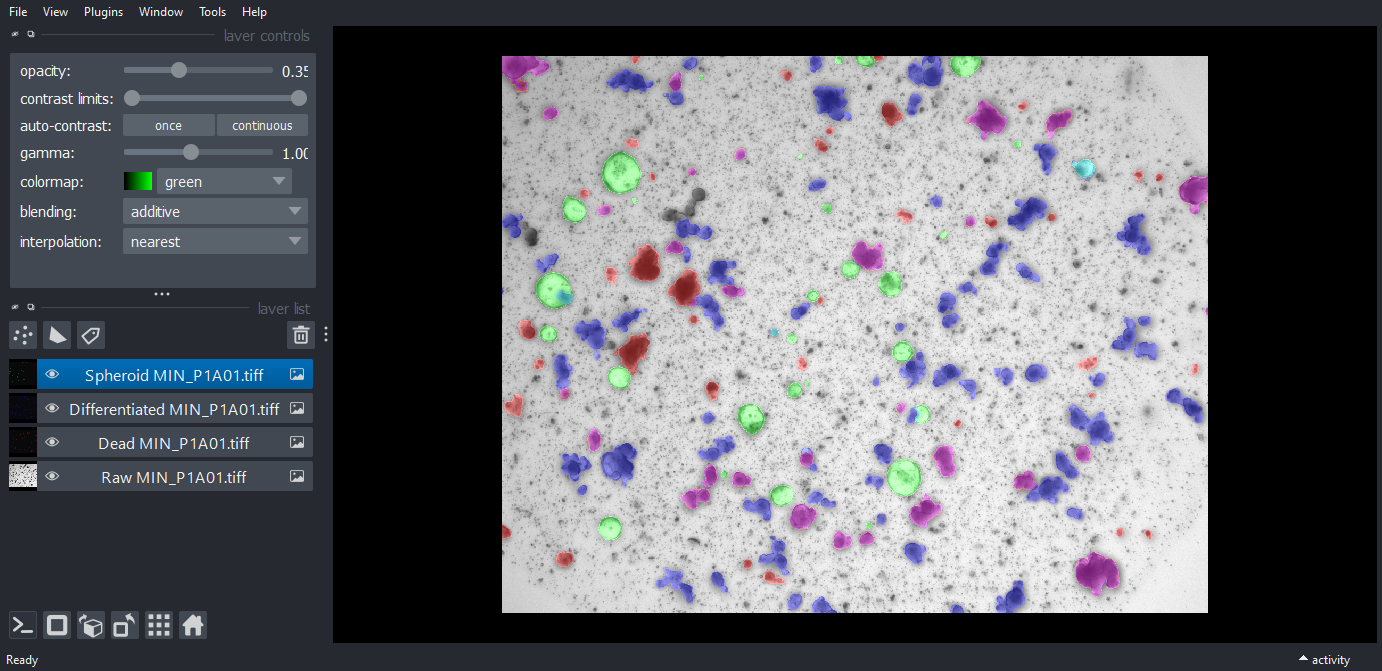

In [23]:
# Define below the filename you want to display together with the corresponding classes
file = "MIN_P1A01.tiff"

# Initialize Napari instance to display raw_images together with class masks
viewer = napari.Viewer(ndisplay=2)

# Read raw image and class labels to display
raw_img = tifffile.imread(f"./processed_bf_organoids/images/{file}", is_ome=False)
dead_mask = tifffile.imread(f"./processed_bf_organoids/masks/dead/{file}", is_ome=False)
diff_mask =  tifffile.imread(f"./processed_bf_organoids/masks/differentiated/{file}", is_ome=False)
undiff_mask = tifffile.imread(f"./processed_bf_organoids/masks/undifferentiated/{file}", is_ome=False)

# Display in Napari
viewer.add_image(raw_img, name=f"Raw {file}")
viewer.add_image(dead_mask, name=f"Dead {file}", colormap="red", opacity=0.35, blending="additive")
viewer.add_image(diff_mask, name=f"Differentiated {file}",colormap="blue", opacity=0.35, blending="additive")
viewer.add_image(undiff_mask, name=f"Spheroid {file}", colormap="green", opacity=0.35, blending="additive")

# Screenshot for documentation purposes
nbscreenshot(viewer)

<h3>Data quality checks</h3>

<p>Counting the number of objects per class in ./processed_bf_organoids/masks using connected component analysis and checking against what's in Apeer's measurements_default.csv file </p>

In [24]:
# Read measurements_default.csv containing each object_id's class_name
df = pd.read_csv("./apeer_annotations/measurements_default.csv")

# Convert 'class_name' values to lowercase
df['class_name'] = df['class_name'].str.lower()

In [25]:
# Display the dataframe containing all Apeer derived measurements
df.head()

,file_name,class_name,time,z,well_id,object_id,area,area_um2,bbox_y_start,bbox_y_start_um,...,filled_area,filled_area_um2,major_axis_length,major_axis_length_um,minor_axis_length,minor_axis_length_um,orientation,perimeter,perimeter_um,solidity
0,MIN_StackC01,dead,1,1,A1,1,428,7.998418e+15,13,5.619834e+07,...,428,7.998418e+15,24.715452,1.068437e+08,22.219819,9.605516e+07,-0.675140,76.183766,3.293386e+08,0.957494
1,MIN_StackC01,dead,1,1,A1,2,529,9.885895e+15,133,5.749523e+08,...,529,9.885895e+15,26.578549,1.148977e+08,25.479090,1.101448e+08,-1.520972,85.012193,3.675034e+08,0.958333
2,MIN_StackC01,dead,1,1,A1,3,783,1.463262e+16,274,1.184488e+09,...,783,1.463262e+16,36.811543,1.591344e+08,28.224519,1.220132e+08,0.191509,112.325902,4.855792e+08,0.932143
3,MIN_StackC01,dead,1,1,A1,4,361,6.746329e+15,76,3.285442e+08,...,361,6.746329e+15,25.020680,1.081631e+08,18.514458,8.003707e+07,0.494603,70.526912,3.048843e+08,0.960106
4,MIN_StackC01,dead,1,1,A1,5,5328,9.956909e+16,14,6.052129e+07,...,5328,9.956909e+16,97.666795,4.222086e+08,78.028768,3.373144e+08,-1.023491,374.333044,1.618223e+09,0.805564


In [26]:
object_class_names = ["dead", "undifferentiated", "differentiated"]

In [27]:

# Create an empty dictionary to store skimage-derived object_counts from masks stored in masks
object_counts = {}

# Iterate over all 3 different classes
for object_class in tqdm(object_class_names):
    
    # Initialize dictionary for the current object class
    object_class_dict = {}

    # Define path containing train masks for each object_class
    processed_annotations = Path(f"./processed_bf_organoids/masks/{object_class}")

    filepaths = []

    # Iterate through the files in the directory
    for file_path in processed_annotations.glob('*.tiff'):
        # Append the file to the filepaths list
        filepaths.append(str(file_path))
        
    # Iterate over all the files in the directory    
    for filepath in filepaths:
    
        # Extract the filename without the extension
        filename = Path(filepath).stem
    
        # Read the .tiff file containing the class mask
        img = tifffile.imread(filepath, is_ome=False)
        
        # Count the number of objects in the image using connected component analysis and return its count
        labeled_image, count = measure.label(img, return_num=True)
        
        # Update the dictionary for the current object class with filename:count key:value pair
        object_class_dict[filename] = count

        # Condition you want to check
        condition = (df['file_name'] == filename) & (df['class_name'] == object_class)

        # Filter the DataFrame based on the conditions
        filtered_df = df.loc[condition]

        # Find the maximum value in the "object_id" column
        max_object_id = filtered_df['object_id'].max()

        # Print statement check
        # print(f"Max object_id for file_name == '{filename}' and class_name == '{object_class}':", max_object_id)
        # print(f"Number of {object_class} objects detected by connected component analysis using skimage.measure.label: {count}")

    # Store the results for the current object class in the main dictionary
    object_counts[object_class] = object_class_dict

100%|██████████| 3/3 [00:06<00:00,  2.31s/it]


In [28]:
# Convert the dictionary to a Pandas DataFrame
df_from_dict = pd.DataFrame([(class_name, file_name, count) for class_name, file_dict in object_counts.items() for file_name, count in file_dict.items()],
                          columns=['class_name', 'file_name', 'cca_object_counts'])

# Merge df_result with df on 'file_name' and 'class_name'
merged_df = pd.merge(df, df_from_dict, on=['file_name', 'class_name'], how='right')

# Fill NaN values in 'object_id' and 'cca_object_counts' with 0 to avoid na errors later
merged_df['object_id'].fillna(0, inplace=True)
merged_df['cca_object_counts'].fillna(0, inplace=True)

# Filter rows where 'object_id' is equal to its maximum value
max_object_id_rows = merged_df.loc[merged_df.groupby(['file_name', 'class_name'])['object_id'].idxmax()]

# Create a new DataFrame with the specified columns (new copy)
result_df = max_object_id_rows[['file_name', 'class_name', 'object_id', 'cca_object_counts']].copy()

# Rename the 'object_id' column to 'apeer_object_counts'
result_df.rename(columns={'object_id': 'apeer_object_counts'}, inplace=True)

# Convert 'apeer_object_counts' to integers
result_df['apeer_object_counts'] = result_df['apeer_object_counts'].astype(int)

# Calculate percentage difference
result_df['perc_error'] = ((result_df['apeer_object_counts'] - result_df['cca_object_counts']) / result_df['apeer_object_counts']) * 100

# Take the absolute value of 'perc_error'
result_df['perc_error'] = result_df['perc_error'].abs()

# Create 'qc_passed' column based on the condition
result_df['qc_passed'] = result_df['perc_error'] < 10

# Print the resulting DataFrame
result_df.head()

,file_name,class_name,apeer_object_counts,cca_object_counts,perc_error,qc_passed
64,MIN_P1A01,dead,65,68,4.615385,True
25004,MIN_P1A01,differentiated,92,93,1.086957,True
8357,MIN_P1A01,undifferentiated,30,30,0.000000,True
137,MIN_P1A02,dead,73,75,2.739726,True
25113,MIN_P1A02,differentiated,109,110,0.917431,True


In [29]:
# Filter result_df by qc_passed == False
failed_qc_df = result_df[result_df['qc_passed'] == False]

# Get unique file_names where qc_passed is False
failed_qc_file_names = failed_qc_df['file_name'].unique().tolist()

# Print the list
print(failed_qc_file_names)

# Print the filtered DataFrame
failed_qc_df.head()

['MIN_P1B01', 'MIN_P1B02', 'MIN_P1B04', 'MIN_P1C04', 'MIN_P1C05', 'MIN_P1C06', 'MIN_P1D01', 'MIN_P1D02', 'MIN_P1D03', 'MIN_P1D05', 'MIN_P1D06', 'MIN_P2A01', 'MIN_P2A02', 'MIN_P2A06', 'MIN_StackA01', 'MIN_StackA05', 'MIN_StackB01', 'MIN_StackB02', 'MIN_StackB03', 'MIN_StackB04', 'MIN_StackB05', 'MIN_StackB06', 'MIN_StackC02', 'MIN_StackC04', 'MIN_StackD01', 'MIN_StackD02', 'MIN_StackD03', 'MIN_StackP1D3A01', 'MIN_StackP1D3B01', 'MIN_StackP1D3B02', 'MIN_StackP1D3B03', 'MIN_StackP1D3D01', 'MIN_StackP1D3D02', 'MIN_StackP1D3D03', 'MIN_StackP2D3C04', 'MIN_StackP2D3D01', 'MIN_StackP2D3D05', 'MIN_stack_A03', 'MIN_stack_B02', 'MIN_stack_B03', 'MIN_stack_C03', 'MIN_stack_C06', 'MIN_stack_D01', 'MIN_stack_D02']


,file_name,class_name,apeer_object_counts,cca_object_counts,perc_error,qc_passed
474,MIN_P1B01,dead,70,83,18.571429,False
8688,MIN_P1B02,undifferentiated,84,67,20.238095,False
631,MIN_P1B04,dead,36,42,16.666667,False
1024,MIN_P1C04,dead,63,70,11.111111,False
1083,MIN_P1C05,dead,59,67,13.559322,False


In [30]:
# Display all masks that have not passed the QC for manual inspection
for file in failed_qc_file_names:

    # Initialize Napari instance to display raw_images together with class masks
    viewer = napari.Viewer(ndisplay=2)

    # Read raw image and class labels to display
    raw_img = tifffile.imread(f"./processed_bf_organoids/images/{file}.tiff", is_ome=False)
    dead_mask = tifffile.imread(f"./processed_bf_organoids/masks/dead/{file}.tiff", is_ome=False)
    diff_mask =  tifffile.imread(f"./processed_bf_organoids/masks/differentiated/{file}.tiff", is_ome=False)
    undiff_mask = tifffile.imread(f"./processed_bf_organoids/masks/undifferentiated/{file}.tiff", is_ome=False)

    # Display in Napari
    viewer.add_image(raw_img, name=f"Raw {file}")
    viewer.add_image(dead_mask, name=f"Dead {file}", colormap="red", opacity=0.35, blending="additive")
    viewer.add_image(diff_mask, name=f"Differentiated {file}",colormap="blue", opacity=0.35, blending="additive")
    viewer.add_image(undiff_mask, name=f"Spheroid {file}", colormap="green", opacity=0.35, blending="additive")

<h3>Train and validation dataset split</h3>
<p>We'll allocate 80% of our data for training and 20% for validation purposes and create all the folder structure for our training dataset</p>

In [31]:
object_class_names = ["dead", "undifferentiated", "differentiated"]

# Define paths
output_folder = './training_data'

# Create training and validation folders
train_image_folder = os.path.join(output_folder, 'train_images')
train_mask_folder = os.path.join(output_folder, 'train_masks')
val_image_folder = os.path.join(output_folder, 'val_images')
val_mask_folder = os.path.join(output_folder, 'val_masks')

os.makedirs(train_image_folder, exist_ok=True)
os.makedirs(train_mask_folder, exist_ok=True)
os.makedirs(val_image_folder, exist_ok=True)
os.makedirs(val_mask_folder, exist_ok=True)

# Create subfolders for all classes within train_masks and val_masks
for object_class in object_class_names:
    os.mkdir(os.path.join(train_mask_folder, object_class))
    os.mkdir(os.path.join(val_mask_folder, object_class))

# Get all filenames

# Define path containing all raw images in order to extract the filenames
processed_bf_organoids = Path(f"./processed_bf_organoids/images")

filenames = []

# Iterate through the files in the directory
for filepath in processed_bf_organoids.glob('*.tiff'):
    # Extract the filename with the .tiff extension
    filename = Path(filepath).name
    # Append the file to the filepaths list
    filenames.append(str(filename))
    
# Split filenames into train and validation sets
train_image_filenames, val_image_filenames = train_test_split(filenames, test_size=0.2, random_state=42)

train_percentage = round((len(train_image_filenames) / (len(train_image_filenames)+len(val_image_filenames))) * 100)
val_percentage = round((len(val_image_filenames) / (len(train_image_filenames)+len(val_image_filenames))) * 100)
print(f"Number of training images: {len(train_image_filenames)}. {train_percentage}% of ground truth dataset")
print(f"Number of validation images: {len(val_image_filenames)}. {val_percentage}% of ground truth dataset")

Number of training images: 95. 80% of ground truth dataset
Number of validation images: 24. 20% of ground truth dataset


<p>Then we'll copy each file into training_data according to the train - validation split above</p>

In [32]:
object_class_names = ["dead", "undifferentiated", "differentiated"]

# Copy raw images into train_images and val_images
print("Copying training images into ./training_data/train_images:")
for filename in tqdm(train_image_filenames):
    source_path = Path(f'./processed_bf_organoids/images/{filename}')
    destination_path = Path(f'./training_data/train_images/{filename}')
    shutil.copy(source_path, destination_path)

print("Copying validation images into ./training_data/val_images:")    
for filename in tqdm(val_image_filenames):
    source_path = Path(f'./processed_bf_organoids/images/{filename}')
    destination_path = Path(f'./training_data/val_images/{filename}')
    shutil.copy(source_path, destination_path)


# Copy masks into train_masks and val_masks under their respective class subfolders
for object_class in object_class_names:
    
    print(f"Copying {object_class} class masks into ./training_data/train_masks: ")
    for filename in tqdm(train_image_filenames):
        source_path = Path(f'./processed_bf_organoids/masks/{object_class}/{filename}')
        destination_path = Path(f'./training_data/train_masks/{object_class}/{filename}')
        shutil.copy(source_path, destination_path)
    
    print(f"Copying {object_class} class masks into ./training_data/val_masks: ")
    for filename in tqdm(val_image_filenames):
        source_path = Path(f'./processed_bf_organoids/masks/{object_class}/{filename}')
        destination_path = Path(f'./training_data/val_masks/{object_class}/{filename}')
        shutil.copy(source_path, destination_path)

Copying training images into ./training_data/train_images:


100%|██████████| 95/95 [00:00<00:00, 186.96it/s]


Copying validation images into ./training_data/val_images:


100%|██████████| 24/24 [00:00<00:00, 105.16it/s]


Copying dead class masks into ./training_data/train_masks: 


100%|██████████| 95/95 [00:00<00:00, 593.20it/s]


Copying dead class masks into ./training_data/val_masks: 


100%|██████████| 24/24 [00:00<00:00, 597.61it/s]


Copying undifferentiated class masks into ./training_data/train_masks: 


100%|██████████| 95/95 [00:00<00:00, 636.82it/s]


Copying undifferentiated class masks into ./training_data/val_masks: 


100%|██████████| 24/24 [00:00<00:00, 651.46it/s]


Copying differentiated class masks into ./training_data/train_masks: 


100%|██████████| 95/95 [00:00<00:00, 189.67it/s]


Copying differentiated class masks into ./training_data/val_masks: 


100%|██████████| 24/24 [00:00<00:00, 645.46it/s]
